## Description

Build and train a multimodal deep neural network for sentiment recognition using tf.keras/pytorch on the MOSI dataset, which contains more than 2000 short videos.

Every video has a single label, which is a continuous value in range [-3, +3].

The following tasks are defined on this dataset:
* regression: using the raw values between [-3, +3]
* classification with 2 classes: [-3, +3] values are converted to 2 classes: negative and positive.

## Optional

Try to use different input modalities.

Examples:
* OpenFace for visual features like face RGB texture, face landmarks, Action Units, Gaze direction.
* openSMILE for hand-crafted audio features.
* VGGish for deep audio features.
* Other deep visual or audio features using any pretrained network available on GitHub.
* Optical Flow, Dynamic Images or other methods in literature for introducing motion information...

## Optional

Use Transformers as submodels. This may take longer to train, or requires more GPU memory, which can be constrained by Colab. Keep it in mind.

## Tip

Downloading the dataset and preprocessing may require more storage, than Colab lend you. You should download the data and preprocess it locally (computer/laptop/tamagotchi). Then create a pickle file, which is preferably less than 5 Gb - This can be uploaded to your Google Drive, and import it in Colab only once. (Uploading the data is also done once this way.)


# The task 

## Imports

In [ ]:
!pip install git+https://github.com/pytorch/tnt.git@master
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

  Cloning https://github.com/pytorch/tnt.git (to revision master) to /tmp/pip-req-build-4qdpgxqe
  Running command git clone -q https://github.com/pytorch/tnt.git /tmp/pip-req-build-4qdpgxqe
     |████████████████████████████████| 676 kB 4.5 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.5.1-py3-none-any.whl size=30937 sha256=3a75481477ace9133ccd549d8241fcab08ef5c98094da75d0d359ce9f8f2af2f
  Stored in directory: /tmp/pip-ephem-wheel-cache-fbhdjsrp/wheels/c2/47/e4/e72a53d93e256eda0cb080447f0376fcde2eac7d3b46c4b8e7
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=ed92a531e69b6a5136a2f12510b49a6b56ee512584a50969f46ca1f4bb8bd2d9
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5709 sha256=6bb3ac6d91ed5d9d473b9a1096eb9db913d29b4d9e432db3e1c06b4e3d43887f

In [ ]:
!pip install torchinfo

In [ ]:
import os
import pandas as pd
from pathlib import Path
import numpy as np
import torch
import random
import json
import cv2

from torch.nn import functional as F

from torchinfo   import summary
from torchvision import models, transforms
from skimage.io import imread
import matplotlib.pyplot as plt
 
from PIL import Image
import h5py
import gc
 
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
import torchnet as tnt
 
import torch.optim as optim

from torch.utils.data import DataLoader,sampler,Dataset
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data.sampler import Sampler,WeightedRandomSampler


In [ ]:

use_cuda = torch.cuda.is_available()
print('use cuda: %s'%(use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


use cuda: True


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:

s = 32
dev = torch.device('cuda')
torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))


CUDA_LAUNCH_BLOCKING = "1"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/call_lld.zip /content/all_lld.zip 

In [ ]:
#!cp -r /content/drive/MyDrive/out_audio.zip /content/out_audio.zip 

In [ ]:
!cp -r /content/drive/MyDrive/call_f.zip /content/all_f.zip 

In [ ]:
!cp -r /content/drive/MyDrive/processed.zip /content/processed.zip 

In [ ]:
!unzip processed.zip -d processed

Streaming output truncated to the last 5000 lines.
  inflating: processed/ZUXBRvtny7o_4_aligned/frame_det_00_000033.bmp  
  inflating: processed/ZUXBRvtny7o_4_aligned/frame_det_00_000034.bmp  
  inflating: processed/ZUXBRvtny7o_4_aligned/frame_det_00_000035.bmp  
  inflating: processed/ZUXBRvtny7o_4_aligned/frame_det_00_000036.bmp  
  inflating: processed/ZUXBRvtny7o_4_aligned/frame_det_00_000037.bmp  
  inflating: processed/ZUXBRvtny7o_4_aligned/frame_det_00_000038.bmp  
  inflating: processed/ZUXBRvtny7o_4_aligned/frame_det_00_000039.bmp  
  inflating: processed/ZUXBRvtny7o_4_aligned/frame_det_00_000040.bmp  
  inflating: processed/ZUXBRvtny7o_4_aligned/frame_det_00_000041.bmp  
  inflating: processed/ZUXBRvtny7o_4_aligned/frame_det_00_000042.bmp  
  inflating: processed/ZUXBRvtny7o_4_aligned/frame_det_00_000043.bmp  
  inflating: processed/ZUXBRvtny7o_4_aligned/frame_det_00_000044.bmp  
  inflating: processed/ZUXBRvtny7o_4_aligned/frame_det_00_000045.bmp  
  inflating: processed/ZUX

In [ ]:
!unzip all_lld.zip -d all_lld

Archive:  all_lld.zip
   creating: all_lld/content/call_lld/
  inflating: all_lld/content/call_lld/Sqr0AcuoNnk_1_audio_lld.csv  
  inflating: all_lld/content/call_lld/f_pcplsH_V0_12_audio_lld.csv  
  inflating: all_lld/content/call_lld/fvVhgmXxadc_1_audio_lld.csv  
  inflating: all_lld/content/call_lld/c7UH_rxdZv4_15_audio_lld.csv  
  inflating: all_lld/content/call_lld/etzxEpPuc6I_15_audio_lld.csv  
  inflating: all_lld/content/call_lld/d3_k5Xpfmik_19_audio_lld.csv  
  inflating: all_lld/content/call_lld/f_pcplsH_V0_7_audio_lld.csv  
  inflating: all_lld/content/call_lld/9qR7uwkblbs_28_audio_lld.csv  
  inflating: all_lld/content/call_lld/2WGyTLYerpo_23_audio_lld.csv  
  inflating: all_lld/content/call_lld/dq3Nf_lMPnE_6_audio_lld.csv  
  inflating: all_lld/content/call_lld/c7UH_rxdZv4_1_audio_lld.csv  
  inflating: all_lld/content/call_lld/POKffnXeBds_8_audio_lld.csv  
  inflating: all_lld/content/call_lld/1iG0909rllw_10_audio_lld.csv  
  inflating: all_lld/content/call_lld/2WGyTLYerp

In [ ]:
!unzip all_f.zip -d all_f

Archive:  all_f.zip
   creating: all_f/content/call_f/
  inflating: all_f/content/call_f/OQvJTdtJ2H4_16_audio_f.csv  
  inflating: all_f/content/call_f/bOL9jKpeJRs_9_audio_f.csv  
  inflating: all_f/content/call_f/BvYR0L6f2Ig_11_audio_f.csv  
  inflating: all_f/content/call_f/_dI--eQ6qVU_3_audio_f.csv  
  inflating: all_f/content/call_f/WKA5OygbEKI_5_audio_f.csv  
  inflating: all_f/content/call_f/TvyZBvOMOTc_6_audio_f.csv  
  inflating: all_f/content/call_f/Iu2PFX3z_1s_11_audio_f.csv  
  inflating: all_f/content/call_f/6_0THN4chvY_7_audio_f.csv  
  inflating: all_f/content/call_f/d6hH302o4v8_13_audio_f.csv  
  inflating: all_f/content/call_f/Oz06ZWiO20M_13_audio_f.csv  
  inflating: all_f/content/call_f/BioHAh1qJAQ_9_audio_f.csv  
  inflating: all_f/content/call_f/Sqr0AcuoNnk_12_audio_f.csv  
  inflating: all_f/content/call_f/Af8D0E4ZXaw_14_audio_f.csv  
  inflating: all_f/content/call_f/BioHAh1qJAQ_20_audio_f.csv  
  inflating: all_f/content/call_f/G6GlGvlkxAQ_6_audio_f.csv  
  infla

In [ ]:
#!unzip out_audio.zip -d out_audio

In [ ]:
"""
all_f=[]
for file in os.listdir('all_f/content/all_f'):
  all_f.append(pd.read_csv('all_f/content/all_f/'+file))
"""

"\nall_f=[]\nfor file in os.listdir('all_f/content/all_f'):\n  all_f.append(pd.read_csv('all_f/content/all_f/'+file))\n"

In [ ]:
"""
all_lld=[]
for file in os.listdir('all_lld/content/all_lld'):
  all_lld.append(pd.read_csv('all_lld/content/all_lld/'+file))
"""  

"\nall_lld=[]\nfor file in os.listdir('all_lld/content/all_lld'):\n  all_lld.append(pd.read_csv('all_lld/content/all_lld/'+file))\n"

## Fetch original data and labels

In [ ]:
VIDEO_DIR = 'MOSI/videos'
LABEL_PATH = 'MOSI/labels.csv'

In [ ]:
labels = pd.read_csv(LABEL_PATH)
labels['Sentiment_Binary'] = (labels['Sentiment'] == 'positive').astype(int)
labels = labels.drop(['Start', 'End', 'Sentiment'], axis=1)
labels.head()

Filename  Score   Type  Sentiment_Binary
0  03bSnISJMiM_1   2.40  train                 1
1  03bSnISJMiM_2  -0.80  train                 0
2  03bSnISJMiM_3  -1.00  train                 0
3  03bSnISJMiM_4  -1.75  train                 0
4  03bSnISJMiM_5   0.00  train                 1

In [ ]:
class MosiDataset(torch.utils.data.Dataset):
   def __init__(self, labels: pd.DataFrame, path: str):
      self.labels = labels
      self.path = Path(path)
    
   def __len__(self):
      return len(self.labels)
  
   def __getitem__(self, index):
      # determine sample
      sample = self.labels.iloc[index]
      id = str(sample['Filename'])

      # get input data
      X = np.array(str(self.path / f'{id}.mp4')) # now, it is the video path for debugging purposes
      # X = np.load(str(self.path / f'{id}.npy')) # you can load precomputed opensmile/openface features
      # X = [
      #   np.load(str(self.path_features1 / f'{id}.npy')),
      #   np.load(str(self.path_features2 / f'{id}.npy'))
      # ] # you can load multiple input modalities

      # get target label
      # y = float(sample['Score']) # for regression
      y = float(sample['Sentiment_Binary']) # for classification
      return X, y

In [ ]:
all_set = MosiDataset(labels, VIDEO_DIR)

In [ ]:

for i, (X, y) in enumerate(all_set):
   #i index in labels too
  
  framelist = os.listdir('processed/'+str(X)[12:-4]+'_aligned/')  
  number_files = len(framelist)
  if(number_files < 10):
    labels = labels[labels.Filename != str(X)[12:-4]]

    #labels.drop(index=i,inplace=True)  
    print(f'X: {X}')
    print(i, '='*40)

labels = labels[labels.Filename != '8qrpnFRGt2A_14']


all_set = MosiDataset(labels, VIDEO_DIR)   

X: MOSI/videos/8qrpnFRGt2A_13.mp4
348 ========================================
X: MOSI/videos/9qR7uwkblbs_33.mp4
456 ========================================


In [ ]:
!rm processed.zip
!rm all_lld.zip
!rm all_f.zip
!rm MOSI.zip 

In [ ]:
train_labels = labels[labels['Type'] == 'train']
print('Number of labels in train:', len(train_labels))
train_labels.head()

Number of labels in train: 1281


Filename  Score   Type  Sentiment_Binary
0  03bSnISJMiM_1   2.40  train                 1
1  03bSnISJMiM_2  -0.80  train                 0
2  03bSnISJMiM_3  -1.00  train                 0
3  03bSnISJMiM_4  -1.75  train                 0
4  03bSnISJMiM_5   0.00  train                 1

In [ ]:
valid_labels = labels[labels['Type'] == 'valid']
print('Number of labels in valid:', len(valid_labels))
valid_labels.head()

Number of labels in valid: 229


Filename  Score   Type  Sentiment_Binary
1284  WKA5OygbEKI_1    1.8  valid                 1
1285  WKA5OygbEKI_2    2.2  valid                 1
1286  WKA5OygbEKI_3    1.2  valid                 1
1287  WKA5OygbEKI_4    1.8  valid                 1
1288  WKA5OygbEKI_5    0.6  valid                 1

In [ ]:
test_labels = labels[labels['Type'] == 'test']
print('Number of labels in test:', len(test_labels))
test_labels.head()

Number of labels in test: 686


Filename  Score  Type  Sentiment_Binary
1513  c7UH_rxdZv4_1   -2.8  test                 0
1514  c7UH_rxdZv4_2   -2.6  test                 0
1515  c7UH_rxdZv4_3   -0.8  test                 0
1516  c7UH_rxdZv4_4    1.6  test                 1
1517  c7UH_rxdZv4_5   -2.2  test                 0

In [ ]:
video_list = [os.path.join(VIDEO_DIR, name) for name in os.listdir(VIDEO_DIR)]
print('[All] Number of videos:', len(video_list))
print('[All] Examples:', video_list[:3])

[All] Number of videos: 2199
[All] Examples: ['MOSI/videos/VbQk4H8hgr0_46.mp4', 'MOSI/videos/Ci-AH39fi3Y_44.mp4', 'MOSI/videos/Njd1F0vZSm4_12.mp4']


In [ ]:
train_video_list = sorted([name for name in video_list if Path(name).stem in set(train_labels['Filename'])])
print('[Train] Number of videos:', len(train_video_list))
print('[Train] Examples:', train_video_list[:3])

[Train] Number of videos: 1281
[Train] Examples: ['MOSI/videos/03bSnISJMiM_1.mp4', 'MOSI/videos/03bSnISJMiM_10.mp4', 'MOSI/videos/03bSnISJMiM_11.mp4']


In [ ]:
valid_video_list = sorted([name for name in video_list if Path(name).stem in set(valid_labels['Filename'])])
print('[Valid] Number of videos:', len(valid_video_list))
print('[Valid] Examples:', valid_video_list[:3])

[Valid] Number of videos: 229
[Valid] Examples: ['MOSI/videos/WKA5OygbEKI_1.mp4', 'MOSI/videos/WKA5OygbEKI_10.mp4', 'MOSI/videos/WKA5OygbEKI_11.mp4']


In [ ]:
test_video_list = sorted([name for name in video_list if Path(name).stem in set(test_labels['Filename'])])
print('[Test] Number of videos:', len(test_video_list))
print('[Test] Examples:', test_video_list[:3])

[Test] Number of videos: 686
[Test] Examples: ['MOSI/videos/c7UH_rxdZv4_1.mp4', 'MOSI/videos/c7UH_rxdZv4_10.mp4', 'MOSI/videos/c7UH_rxdZv4_11.mp4']


In [ ]:
from IPython.display import HTML
from base64 import b64encode

index = 131
mp4 = open(str(all_set[index][0]),'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)
 

## Extract features

### video

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/TadasBaltrusaitis/OpenFace.git'
project_name = splitext(basename(git_repo_url))[0]
# clone openface
!git clone -q --depth 1 $git_repo_url

# install new CMake becaue of CUDA10
!wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
!tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

# Get newest GCC
!sudo apt-get update
!sudo apt-get install build-essential 
!sudo apt-get install g++-8

# install python dependencies
!pip install -q youtube-dl

# Finally, actually install OpenFace
!cd OpenFace && bash ./download_models.sh && sudo bash ./install.sh

Streaming output truncated to the last 5000 lines.
  inflating: opencv-4.1.0/samples/cpp/tutorial_code/core/mat_mask_operations/mat_mask_operations.cpp  
   creating: opencv-4.1.0/samples/cpp/tutorial_code/core/mat_operations/
  inflating: opencv-4.1.0/samples/cpp/tutorial_code/core/mat_operations/mat_operations.cpp  
   creating: opencv-4.1.0/samples/cpp/tutorial_code/core/mat_the_basic_image_container/
  inflating: opencv-4.1.0/samples/cpp/tutorial_code/core/mat_the_basic_image_container/mat_the_basic_image_container.cpp  
   creating: opencv-4.1.0/samples/cpp/tutorial_code/features2D/
  inflating: opencv-4.1.0/samples/cpp/tutorial_code/features2D/AKAZE_match.cpp  
   creating: opencv-4.1.0/samples/cpp/tutorial_code/features2D/AKAZE_tracking/
  inflating: opencv-4.1.0/samples/cpp/tutorial_code/features2D/AKAZE_tracking/planar_tracking.cpp  
  inflating: opencv-4.1.0/samples/cpp/tutorial_code/features2D/AKAZE_tracking/stats.h  
  inflating: opencv-4.1.0/samples/cpp/tutorial_code/featu

In [ ]:

for i, (X, y) in enumerate(all_set):
  pX='processed/'+X[:-4]+'.avi'
  oX='out_processed/'+X[:-4]+_output.mp4'
  !./OpenFace/build/bin/FeatureExtraction -f $X -out_dir processed
#5h

Streaming output truncated to the last 5000 lines.
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_0.50_of.dat....Done
Reading the intensity CEN patch experts from: ./OpenFace/build/bin/model/patch_experts/cen_patches_1.00_of.dat....Done
Reading part based module....left_eye_28
Reading the landmark detector/tracker from: ./OpenFace/build/bin/model/model_eye/main_clnf_synth_left.txt
Reading the landmark detector module from: ./OpenFace/build/bin/model/model_eye/clnf_left_synth.txt
Reading the PDM module from: ./OpenFace/build/bin/model/model_eye/pdms/pdm_28_l_eye_3D_closed.txt....Done
Reading the intensity CCNF patch experts from: ./OpenFace/build/bin/model/model_eye/patch_experts/left_ccnf_patches_1.00_synth_lid_.txt....Done
Reading the intensity CCNF patch experts from: ./OpenFace/build/bin/model/model_eye/patch_experts/left_ccnf_patches_1.50_synth_lid_.txt....Done
Could not find the HAAR face detector location
Done
Reading part based

In [ ]:
!zip -r processed.zip /content/processed
#23min

Streaming output truncated to the last 5000 lines.
  adding: content/processed/ob23OKe5a9Q_9_aligned/frame_det_00_000042.bmp (deflated 58%)
  adding: content/processed/ob23OKe5a9Q_9_aligned/frame_det_00_000318.bmp (deflated 46%)
  adding: content/processed/ob23OKe5a9Q_9_aligned/frame_det_00_000416.bmp (deflated 49%)
  adding: content/processed/ob23OKe5a9Q_9_aligned/frame_det_00_000461.bmp (deflated 49%)
  adding: content/processed/ob23OKe5a9Q_9_aligned/frame_det_00_000306.bmp (deflated 46%)
  adding: content/processed/ob23OKe5a9Q_9_aligned/frame_det_00_000014.bmp (deflated 51%)
  adding: content/processed/ob23OKe5a9Q_9_aligned/frame_det_00_000187.bmp (deflated 50%)
  adding: content/processed/ob23OKe5a9Q_9_aligned/frame_det_00_000152.bmp (deflated 47%)
  adding: content/processed/ob23OKe5a9Q_9_aligned/frame_det_00_000858.bmp (deflated 49%)
  adding: content/processed/ob23OKe5a9Q_9_aligned/frame_det_00_000188.bmp (deflated 49%)
  adding: content/processed/ob23OKe5a9Q_9_aligned/frame_det

In [ ]:
for i, (X, y) in enumerate(all_set):
  pX='processed/'+str(X)[12:-4]+'.avi'
  oX='out_processed/'+str(X)[12:-4]+'_output.mp4'
  !ffmpeg -y -loglevel info -i $pX $oX

Streaming output truncated to the last 5000 lines.
[libx264 @ 0x559bbafb7e00] 8x8 transform intra:69.2% inter:71.9%
[libx264 @ 0x559bbafb7e00] coded y,uvDC,uvAC intra: 33.8% 50.6% 12.8% inter: 9.1% 23.5% 15.2%
[libx264 @ 0x559bbafb7e00] i16 v,h,dc,p: 25% 40% 21% 14%
[libx264 @ 0x559bbafb7e00] i8 v,h,dc,ddl,ddr,vr,hd,vl,hu: 16% 29% 49%  1%  1%  1%  1%  1%  1%
[libx264 @ 0x559bbafb7e00] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 34% 27% 20%  2%  3%  4%  4%  3%  3%
[libx264 @ 0x559bbafb7e00] i8c dc,h,v,p: 46% 26% 27%  1%
[libx264 @ 0x559bbafb7e00] Weighted P-Frames: Y:0.0% UV:0.0%
[libx264 @ 0x559bbafb7e00] ref P L0: 69.3% 10.2% 13.9%  6.6%
[libx264 @ 0x559bbafb7e00] ref B L0: 85.8% 11.8%  2.4%
[libx264 @ 0x559bbafb7e00] ref B L1: 95.9%  4.1%
[libx264 @ 0x559bbafb7e00] kb/s:451.21
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib

###audio

In [ ]:
!pip install opensmile
import opensmile


     |████████████████████████████████| 4.5 MB 5.2 MB/s 
     |████████████████████████████████| 47 kB 3.2 MB/s 
     |████████████████████████████████| 635 kB 42.1 MB/s 
     |████████████████████████████████| 596 kB 42.6 MB/s 
     |████████████████████████████████| 167 kB 53.1 MB/s 
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=169061 sha256=1309480bfabb25e9da1dec4c115084f43ecb82e3ddfae73cf7e024b091038667
  Stored in directory: /root/.cache/pip/wheels/47/60/19/6d020fc92138ed1b113a18271e83ea4b5525fe770cb45b9a2e
Successfully built iso-639
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [ ]:
for i, (X, y) in enumerate(all_set):
  pX='MOSI/videos/'+str(X)[12:-4]+'.mp4'
  oX='out_audio/'+str(X)[12:-4]+'_audio.wav'
  !ffmpeg -y -loglevel info -i $X $oX

Streaming output truncated to the last 5000 lines.
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf55.30.100
  Duration: 00:00:02.67, start: -0.013061, bitrate: 379 kb/s
    Stream #0:0(und): Video: h264 (High) (avc1 / 0x31637661), yuv420p, 480x360, 236 kb/s, 30 fps, 30 tbr, 15360 tbn, 60 tbc (default)
    Metadata:
      handler_name    : VideoHandler
    Stream #0:1(und): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 128 kb/s (default)
    Metadata:
      handler_name    : SoundHandler
Stream mapping:
  Stream #0:1 -> #0:0 (aac (native) -> pcm_s16le (native))
Press [q] to stop, [?] for help
Output #0, wav, to 'out_audio/vyB00TXsimI_12_audio.wav':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    ISFT            : Lavf57.83.100
    Stream #0:0(und): Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, stereo, s16, 1411 kb/s (default)
    Metadata:
      handler_name    : SoundHandler
      encod

In [ ]:
smile = opensmile.Smile(
    feature_set = opensmile.FeatureSet.ComParE_2016,
    feature_level = opensmile.FeatureLevel.LowLevelDescriptors,
)

In [ ]:
all_lld=[]
for i, (X, y) in enumerate(all_set):
  #oX='out_audio/'+str(X)[12:-4]+'_audio.wav' 
  oX='out_audio/content/out_audio/'+str(X)[12:-4]+'_audio.wav'
  all_lld.append( smile.process_file(oX))

In [ ]:
smile = opensmile.Smile(
    feature_set = opensmile.FeatureSet.ComParE_2016,
    feature_level = opensmile.FeatureLevel.Functionals,
)

In [ ]:
all_f=[]
for i, (X, y) in enumerate(all_set):
   
  oX='out_audio/content/out_audio/'+str(X)[12:-4]+'_audio.wav'
  all_f.append( smile.process_file(oX))



---



In [ ]:
for a in all_lld:
  a.to_csv('call_lld/'+a.index[0][0][28:-4]+'_lld.csv')

In [ ]:
for a in all_f:
  a.to_csv('call_f/'+a.index[0][0][28:-4]+'_f.csv')

In [ ]:
!zip -r out_audio.zip /content/out_audio

  adding: content/out_audio/ (stored 0%)
  adding: content/out_audio/W8NXH0Djyww_22_audio.wav (deflated 32%)
  adding: content/out_audio/Sqr0AcuoNnk_14_audio.wav (deflated 23%)
  adding: content/out_audio/cXypl4FnoZo_8_audio.wav (deflated 10%)
  adding: content/out_audio/lXPQBPVc5Cw_5_audio.wav (deflated 34%)
  adding: content/out_audio/zhpQhgha_KU_25_audio.wav (deflated 29%)
  adding: content/out_audio/0h-zjBukYpk_6_audio.wav (deflated 25%)
  adding: content/out_audio/f_pcplsH_V0_2_audio.wav (deflated 24%)
  adding: content/out_audio/ZUXBRvtny7o_5_audio.wav (deflated 34%)
  adding: content/out_audio/VbQk4H8hgr0_14_audio.wav (deflated 10%)
  adding: content/out_audio/1DmNV9C1hbY_4_audio.wav (deflated 9%)
  adding: content/out_audio/BioHAh1qJAQ_21_audio.wav (deflated 15%)
  adding: content/out_audio/rnaNMUZpvvg_4_audio.wav (deflated 32%)
  adding: content/out_audio/G6GlGvlkxAQ_5_audio.wav (deflated 23%)
  adding: content/out_audio/cW1FSBF59ik_10_audio.wav (deflated 50%)
  adding: conten

In [ ]:
!zip -r call_f.zip /content/call_f

  adding: content/call_f/ (stored 0%)
  adding: content/call_f/OQvJTdtJ2H4_16_audio_f.csv (deflated 81%)
  adding: content/call_f/bOL9jKpeJRs_9_audio_f.csv (deflated 81%)
  adding: content/call_f/BvYR0L6f2Ig_11_audio_f.csv (deflated 81%)
  adding: content/call_f/_dI--eQ6qVU_3_audio_f.csv (deflated 81%)
  adding: content/call_f/WKA5OygbEKI_5_audio_f.csv (deflated 81%)
  adding: content/call_f/TvyZBvOMOTc_6_audio_f.csv (deflated 81%)
  adding: content/call_f/Iu2PFX3z_1s_11_audio_f.csv (deflated 81%)
  adding: content/call_f/6_0THN4chvY_7_audio_f.csv (deflated 81%)
  adding: content/call_f/d6hH302o4v8_13_audio_f.csv (deflated 81%)
  adding: content/call_f/Oz06ZWiO20M_13_audio_f.csv (deflated 81%)
  adding: content/call_f/BioHAh1qJAQ_9_audio_f.csv (deflated 81%)
  adding: content/call_f/Sqr0AcuoNnk_12_audio_f.csv (deflated 81%)
  adding: content/call_f/Af8D0E4ZXaw_14_audio_f.csv (deflated 81%)
  adding: content/call_f/BioHAh1qJAQ_20_audio_f.csv (deflated 81%)
  adding: content/call_f/G6GlG

In [ ]:
!zip -r call_lld.zip /content/call_lld


  adding: content/call_lld/ (stored 0%)
  adding: content/call_lld/Sqr0AcuoNnk_1_audio_lld.csv (deflated 59%)
  adding: content/call_lld/f_pcplsH_V0_12_audio_lld.csv (deflated 59%)
  adding: content/call_lld/fvVhgmXxadc_1_audio_lld.csv (deflated 59%)
  adding: content/call_lld/c7UH_rxdZv4_15_audio_lld.csv (deflated 59%)
  adding: content/call_lld/etzxEpPuc6I_15_audio_lld.csv (deflated 58%)
  adding: content/call_lld/d3_k5Xpfmik_19_audio_lld.csv (deflated 59%)
  adding: content/call_lld/f_pcplsH_V0_7_audio_lld.csv (deflated 59%)
  adding: content/call_lld/9qR7uwkblbs_28_audio_lld.csv (deflated 58%)
  adding: content/call_lld/2WGyTLYerpo_23_audio_lld.csv (deflated 59%)
  adding: content/call_lld/dq3Nf_lMPnE_6_audio_lld.csv (deflated 58%)
  adding: content/call_lld/c7UH_rxdZv4_1_audio_lld.csv (deflated 59%)
  adding: content/call_lld/POKffnXeBds_8_audio_lld.csv (deflated 59%)
  adding: content/call_lld/1iG0909rllw_10_audio_lld.csv (deflated 59%)
  adding: content/call_lld/2WGyTLYerpo_19_a



---



In [ ]:
all_f[0].shape

(1, 6373)

In [ ]:
type(all_lld[0])

pandas.core.frame.DataFrame

In [ ]:
all_lld[350]

F0final_sma  ...  mfcc_sma[14]
file                                               start                  end                                     ...              
out_audio/content/out_audio/8qrpnFRGt2A_17_audi... 0 days 00:00:00        0 days 00:00:00.060000       72.711800  ...      1.031989
                                                   0 days 00:00:00.010000 0 days 00:00:00.070000       89.132050  ...     -0.191272
                                                   0 days 00:00:00.020000 0 days 00:00:00.080000      105.489548  ...     -4.903203
                                                   0 days 00:00:00.030000 0 days 00:00:00.090000        0.000000  ...    -12.983762
                                                   0 days 00:00:00.040000 0 days 00:00:00.100000        0.000000  ...    -17.891747
...                                                                                                          ...  ...           ...
                                                   0 days 00:00:01.320000 0 days 00:00:01.380000        0.000000  ...     -3.855972
                                                   0 days 00:00:01.330000 0 days 00:00:01.390000        0.000000  ...     -4.544585
                                                   0 days 00:00:01.340000 0 days 00:00:01.400000        0.000000  ...     -4.695604
                                                   0 days 00:00:01.350000 0 days 00:00:01.410000        0.000000  ...     -6.075143
                                                                          0 days 00:00:01.416417234     0.000000  ...     -0.962099

[137 rows x 65 columns]

## Train-Valid-Test Dataloaders

In [ ]:
fpi=30
api=90

In [ ]:


class ClipsDatasetLSTMF(Dataset):
     

  def __init__(self,  root_dir,labels=[], transform=None):
    """
    Args:
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    
    self.root_dir = root_dir
    self.transform = transforms.Compose([transforms.ToTensor()])
    self.labels=labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):


    #print(idx)    
    sample = self.labels.iloc[idx]
    id = str(sample['Filename'])

    framelist = os.listdir(self.root_dir+id+'_aligned/')  
    number_files = len(framelist)      
    ratio = int(np.floor(number_files/fpi))
    clip=[]
    if number_files>fpi:
      for i in range(fpi):
        imidx=i*ratio

        #imgname='frame_det_00_'+str(imidx).zfill(6)+'.bmp'
        imgname = framelist[imidx]
        img_path = os.path.join(self.root_dir+id+'_aligned/'+imgname)
        image = Image.open(img_path)
        image=np.array(image)/255
        clip.append(image)

    else:
      for i in range(number_files):
        imgname = framelist[i]
        img_path = os.path.join(self.root_dir+id+'_aligned/'+imgname)
        image = Image.open(img_path)
        image=np.array(image)/255
        clip.append(image)
      for i in range(number_files,fpi):
        image=np.zeros((112,112,3))
        clip.append(image)

    clip=np.asarray(clip)
    clip=np.transpose(clip, (0,3,1,2))
    clip = torch.from_numpy(np.asarray(clip))

    video_feat = pd.read_csv(self.root_dir+id+".csv")
    number_files = len(video_feat.index)      
    ratio = int(np.floor(number_files/fpi))
    if number_files>fpi:
      frames_to_pick = [ i*ratio for i in range(fpi)]
      other_ind = list( set(range(0,number_files)) - set(frames_to_pick))
      video_feat.drop(index= other_ind, inplace=True)
    else: 
      for i in range(number_files,fpi):
        video_feat = video_feat.append(pd.Series(0, index=video_feat.columns), ignore_index=True)

    
    video_feat = torch.from_numpy(video_feat.drop([	'frame',	' face_id',	' timestamp'], axis=1).values)

    
    audio_lld = pd.read_csv("all_lld/content/call_lld/"+id+"_audio_lld.csv")
    
    number_files = len(audio_lld.index)
    if number_files>api:      
      ratio = int(np.floor(number_files/api))
      frames_to_pick = [ i*ratio for i in range(api)]
      other_ind = list( set(range(0,number_files)) - set(frames_to_pick))
      audio_lld.drop(index= other_ind, inplace=True)
    else:
      for i in range(number_files,api):
        audio_lld = audio_lld.append(pd.Series(0, index=audio_lld.columns), ignore_index=True)
    

    
    audio_lld = torch.from_numpy(audio_lld.drop([	'file',	'start',	'end'], axis=1).values)

    audio_f = pd.read_csv("all_f/content/call_f/"+id+"_audio_f.csv")
    audio_f = torch.from_numpy(audio_f.drop(['file','start','end'], axis=1).values)

    
    

    sample={'clip':clip,'video_feat':video_feat,
                  'audio_lld':audio_lld,
            'audio_f':audio_f,'Label':(float(sample['Sentiment_Binary']))}

    return sample






In [ ]:
train_dataset=ClipsDatasetLSTMF(root_dir='./processed/',
                               labels=train_labels)
test_dataset=ClipsDatasetLSTMF(root_dir='./processed/',
                               labels=test_labels)
valid_dataset=ClipsDatasetLSTMF(root_dir='./processed/',
                               labels=valid_labels)

In [ ]:

for i in range(1200,1203):
    sample=train_dataset[i]
    print(sample['clip'].shape)
    #print(sample['Label'])
    #print(sample)
    print(sample['audio_lld'].shape)
    print(sample['audio_f'].shape)
    print(sample['video_feat'].shape)
    print('.'*20)
    

torch.Size([30, 3, 112, 112])
torch.Size([90, 65])
torch.Size([1, 6373])
torch.Size([30, 711])
....................
torch.Size([30, 3, 112, 112])
torch.Size([90, 65])
torch.Size([1, 6373])
torch.Size([30, 711])
....................
torch.Size([30, 3, 112, 112])
torch.Size([90, 65])
torch.Size([1, 6373])
torch.Size([30, 711])
....................


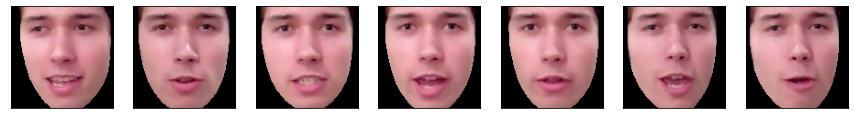

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
sample=train_dataset[random.randint(0,1000)]
plt.figure(figsize=[15, 3])
for j in range(7):
  
  plt.subplot(1,7, j+1)
  plt.xticks([])
  plt.yticks([])
  img =sample['clip'][j]
  imgplot = plt.imshow(image.array_to_img(img,data_format="channels_first"))

In [ ]:
batch_size=24

In [ ]:

class_sample_count = np.array([len(np.where(train_labels['Sentiment_Binary']==t)[0]) for t in np.unique(labels['Sentiment_Binary'])])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in train_labels['Sentiment_Binary']])

samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                               sampler=sampler,
                       )
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                              shuffle=True,
                        )
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size,
                                shuffle=True,
                      )

## Define & Train the model

In [ ]:
class Flatten3d(nn.Module):
    def forward(self, x):
        
        N, C, D, H, W = x.size() 
        return x.view(N, -1)

In [ ]:
class SequenceClassify(nn.Module):
    def __init__(self):
        super(SequenceClassify, self).__init__()



        self.audiof_submodel = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2, stride=2),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=1),
            nn.MaxPool1d(2, stride=2),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv1d(32, 128, kernel_size=5, stride=2, padding=1),
            nn.MaxPool1d(2, stride=2),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(25344, 352),
        )
                
 
 
        self.singleframe_submodel  = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
        self.singleframe_submodel.fc = nn.Identity()

        self.lstm_audiolld =  nn.LSTM(
            input_size=65 ,
            hidden_size=32, 
            num_layers=1,
            batch_first=True)
        self.lstm_video =  nn.LSTM(
            input_size=711, 
            hidden_size=128, 
            num_layers=1,
            batch_first=True)

        self.lstm_frames =  nn.LSTM(
            input_size=512, 
            hidden_size=256, 
            num_layers=1,
            batch_first=True)

        self.shared_layers = nn.Sequential(
            nn.Linear(768, 256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.Hardswish(inplace=True),
            nn.Linear(128, 64),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
        )
        self.project_layer = nn.Linear(64, 2)

    def forward(self, input1, h_t_1=None, c_t_1=None):

        batch_size2, timesteps, C, H, W = input1[0].size()
         
        c_in = input1[0].view(batch_size2 * timesteps, C, H, W).to(device)          #.cuda()
        c_out = self.singleframe_submodel(c_in)
        r_in = c_out.view(batch_size2, timesteps, -1)
        r_out, (h_n, h_c) = self.lstm_frames(r_in)
 
        frame_output=r_out[:, -1, :]

 

        vf_in = input1[1].view( -1,fpi,711).to(device)       #.cuda()
 
        videofeat_output, (h_n, h_c)  = self.lstm_video(vf_in)
        audiof_output = self.audiof_submodel( input1[2].view( -1,1,6373).to(device))    # behind one bracket   .cuda()
        audiolld_output, (h_n, h_c)  = self.lstm_audiolld( input1[3].view( -1,api,65).to(device))  #.cuda()


 

        x = torch.cat((frame_output, videofeat_output[:, -1, :], audiof_output, audiolld_output[:, -1, :]), dim=1)
        x = self.shared_layers(x)
        logits = self.project_layer(x)

         
        return logits
    
    




model = SequenceClassify()
model.to(device)
#model.cuda()

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SequenceClassify(
  (audiof_submodel): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Conv1d(16, 32, kernel_size=(5,), stride=(2,), padding=(1,))
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Conv1d(32, 128, kernel_size=(5,), stride=(2,), padding=(1,))
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linea

In [ ]:

print (summary(model.singleframe_submodel, input_size=(1, 3, 112,112))  )
print (summary(model.lstm_frames, input_size=(1, 30,  512))  )
print (summary(model.lstm_video, input_size=(1, fpi, 711))  )
print (summary(model.audiof_submodel, input_size=(1, 1,6373))  )
print (summary(model.lstm_audiolld, input_size=(1, 17,65))  )
print (summary(model.shared_layers, input_size=(1, 768))  )

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [1, 64, 56, 56]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 56, 56]           128
├─ReLU: 1-3                              [1, 64, 56, 56]           --
├─MaxPool2d: 1-4                         [1, 64, 28, 28]           --
├─Sequential: 1-5                        [1, 64, 28, 28]           --
│    └─BasicBlock: 2-1                   [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-1                  [1, 64, 28, 28]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 28, 28]           128
│    │    └─ReLU: 3-3                    [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-4                  [1, 64, 28, 28]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 28, 28]           128
│    │    └─ReLU: 3-6                    [1, 64, 28, 28]           --
│

In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss().cuda()

global val_loss, val_accuracy, train_loss, train_accuracy
val_loss = []
val_accuracy = []
train_loss = []
train_accuracy = []

In [ ]:
# one epoch takes like 12 minutes, crickey

gc.collect()
torch.cuda.empty_cache()

def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    
    if is_training:
        
        #model.train()
        logger_prefix = 'train'
    else:
        #model.eval()
        logger_prefix = 'val'

    confusion_matrix = tnt.meter.ConfusionMeter(2)
    acc = tnt.meter.ClassErrorMeter(accuracy=True)
    meter_loss = tnt.meter.AverageValueMeter()

    


    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['clip']
        label = sample['Label']
        videofeat = sample['video_feat']
        audiof = sample['audio_f']
        audiolld = sample['audio_lld']
        input_sequence_var = Variable(sequence).to(device).float()  #.cuda().float()
        input_videofeat_var = Variable(videofeat).to(device).float() #.float().cuda()
        input_audiof_var = Variable(audiof).to(device).float()  #.float().cuda()
        input_label_var = Variable(label).to(device).long()#.cuda()
        input_audiolld_var = Variable(audiolld).to(device).float() 
       
        output_logits = model((input_sequence_var, input_videofeat_var, input_audiof_var,input_audiolld_var))
        

        loss = criterion(output_logits, input_label_var)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        meter_loss.add(loss.item())
        acc.add(output_logits.data, input_label_var.data)
        confusion_matrix.add(output_logits.data, input_label_var.data)


    print('%s Epoch: %d  , Loss: %.4f,  Accuracy: %.2f'%(logger_prefix, epoch, meter_loss.value()[0], acc.value()[0]))

    return acc.value()[0], meter_loss.value()[0],confusion_matrix
val_acc = []
val_loss =[]
train_loss =[]
train_acc = []
num_epochs = 20
evaluate_every_epoch = 1
for e in range(1,num_epochs+1):
    #run_epoch(train_dataloader, model, criterion, e, True, optimizer)
    r = run_epoch(train_dataloader, model, criterion, e, True, optimizer)
    train_acc.append(r[0])
    train_loss.append(r[1])
    if e % evaluate_every_epoch == 0:
        r = run_epoch(valid_dataloader, model, criterion, e, False, None) 
        val_acc.append(r[0])
        val_loss.append(r[1])

train Epoch: 1  , Loss: 0.7314,  Accuracy: 54.72
val Epoch: 1  , Loss: 0.6914,  Accuracy: 51.09
train Epoch: 2  , Loss: 0.6838,  Accuracy: 53.79
val Epoch: 2  , Loss: 0.7201,  Accuracy: 48.91
train Epoch: 3  , Loss: 0.6796,  Accuracy: 59.48
val Epoch: 3  , Loss: 0.7862,  Accuracy: 48.47
train Epoch: 4  , Loss: 0.6842,  Accuracy: 57.22
val Epoch: 4  , Loss: 0.7121,  Accuracy: 50.22
train Epoch: 5  , Loss: 0.6597,  Accuracy: 60.66
val Epoch: 5  , Loss: 0.7643,  Accuracy: 51.09
train Epoch: 6  , Loss: 0.6652,  Accuracy: 60.73
val Epoch: 6  , Loss: 0.7849,  Accuracy: 51.53
train Epoch: 7  , Loss: 0.6618,  Accuracy: 59.95
val Epoch: 7  , Loss: 0.7176,  Accuracy: 45.41
train Epoch: 8  , Loss: 0.6847,  Accuracy: 55.19
val Epoch: 8  , Loss: 0.6699,  Accuracy: 60.26
train Epoch: 9  , Loss: 0.6536,  Accuracy: 61.28
val Epoch: 9  , Loss: 0.6994,  Accuracy: 57.64
train Epoch: 10  , Loss: 0.6513,  Accuracy: 62.45
val Epoch: 10  , Loss: 0.7153,  Accuracy: 56.77
train Epoch: 11  , Loss: 0.6559,  Accu

## Evaluation

In [ ]:
epochs = range(1, len(train_loss) + 1)


plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'orange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
r = run_epoch(test_dataloader, model, criterion, 0, False, None) 

In [ ]:
print(pd.DataFrame(r[2])